In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))   
%load_ext autoreload
%autoreload 1

Author: Andrew Tarzia

Date Created: 12 Jul 2018

License:

# Notebook for getting molecule parameters using RDKIT


In [2]:
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors3D import NPR1, NPR2, PMI1, PMI2, PMI3
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Geometry import rdGeometry
from rdkit.Chem import PyMol
from rdkit import Geometry
import tempfile
import matplotlib.pyplot as plt
%aimport rdkit_functions

# Notes:
# Todo:
- timing
 - speed up reading: https://rdkit.blogspot.com/2016/09/avoiding-unnecessary-work-and.html

In [3]:
# molecule file dir
molecule_file = '/home/atarzia/psp/molecules/test_molecules.txt'
# output dir
output_dir = '/home/atarzia/psp/molecules/'

In [4]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])


def define_parity_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


In [7]:
df, molecules, diameters = rdkit_functions.read_mol_txt_file(molecule_file)
rdkit_functions.produce_quick_fig_mol(molecules, output_dir+'test_molecules.pdf')

## Calculate size and shape

In [148]:
try:
    v = PyMol.MolViewer()
except ConnectionRefusedError:
    pass

In [149]:
molecules

{'1,2,4-trimethylbenzene': 'CC1=CC(=C(C=C1)C)C',
 '1-butanol': 'CCCCO',
 '1-butene': 'CCC=C',
 '2,3-dimethylbutane': 'CC(C)C(C)C',
 '3-methylpentane': 'CCC(C)CC',
 'benzene': 'c1ccccc1',
 'carbon dioxide': 'C(=O)=O',
 'ethane': 'CC',
 'ethanol': 'CCO',
 'ethene': 'C=C',
 'ethyl-benzene': 'CCc1ccccc1',
 'i-butane': 'CC(C)C',
 'i-butene': 'CC(=C)C',
 'mesitylene': 'CC1=CC(=CC(=C1)C)C',
 'meta-xylene': 'Cc1cccc(C)c1',
 'methane': 'C',
 'n-butane': 'CCCC',
 'n-hexane': 'CCCCCC',
 'n-propane': 'CCC',
 'nitrogen': 'N#N',
 'ortho-xylene': 'Cc1ccccc1C',
 'oxygen': 'O=O',
 'para-xylene': 'Cc1ccc(C)cc1',
 'propene': 'CC=C',
 'water': 'O'}

molecule: n-hexane : SMILES: CCCCCC
No. of conformers: 1
minimum diameter = 3.801 angstrom
intermediate diameter = 4.406 angstrom


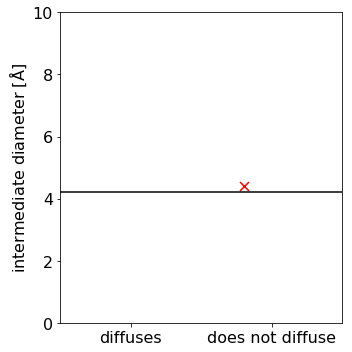

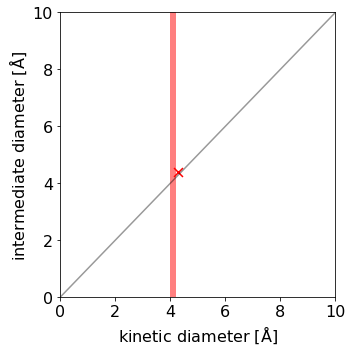

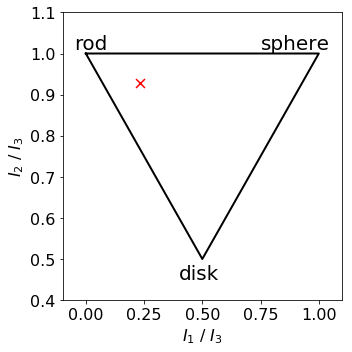

In [189]:
fig1, ax1 = plt.subplots(figsize=(5,5))
fig2, ax2 = plt.subplots(figsize=(5,5))
fig3, ax3 = plt.subplots(figsize=(5,5))
# spacing in X direction
dx = 0.15
# threshold for diffusion through ZIF-8
# from Exploring the Framework Hydrophobicity and Flexibility 
# of ZIF-8: From Biofuel Recovery to Hydrocarbon Separations
threshold = 4.2

min_diam_sums = []
mid_diam_sums = []
avg_diam_sums = []
for T in np.arange(1):
    for name, smile in molecules.items():
        if name != 'n-hexane':
            continue
        print('molecule:', name,':', 'SMILES:', smile)
        try:
            kin_diam = float(diameters[name])
        except ValueError:
            print('no radius given for this molecule - skipped')
            continue

        # Read SMILES and add Hs
        mol = Chem.AddHs(Chem.MolFromSmiles(smile))
        # 2D to 3D
        # with multiple conformers
        cids = Chem.EmbedMultipleConfs(mol, 1) #, Chem.ETKDG())
        print('No. of conformers:', len(cids))
        # quick UFF optimize
        for cid in cids: Chem.UFFOptimizeMolecule(mol, confId=cid)
        # align all conformers
        # Chem.AlignMolConformers(mol, [0])
        # rdkit_functions.show_all_conformers(v, mol, cids)
        mol_coms = rdkit_functions.get_COMs(mol, cids)
        # get principal moments of intertia
        _, _, _, ratio_1_, ratio_2_ = rdkit_functions.get_inertial_prop(mol, cids)
        # print(np.average(ratio_1_), np.average(ratio_2_))
        conf_diameters, conf_axes, conf_moments = rdkit_functions.get_vdw_diameters(mol, cids, 
                                                                    mol_coms, 
                                                                    vdwScale=1.0, 
                                                                    boxMargin=4.0, 
                                                                    spacing=0.5,
                                                                    vec_spacing=0.2,
                                                                    show=False, 
                                                                    plot=False)
        
        # show one conformers axes of inertia in pymol
        # rdkit_functions.show_axes(mol, confId, mol_coms, conf_axes)
        diams = [sorted(i) for i in conf_diameters]
        min_diam = np.average([i[0] for i in diams])  # use the avg min diam
        mid_diam = np.average([i[1] for i in diams])  # use the avg intermediate diam
        print('minimum diameter =', round(min_diam, 3), 'angstrom')
        print('intermediate diameter =', round(mid_diam, 3), 'angstrom')
        min_diam_sums.append(min_diam)
        mid_diam_sums.append(mid_diam) 
        avg_diam_sums.append(np.average([min_diam, mid_diam]))
        # for categorical plot - use the experimental results
        # get the diffusion binary result
        diffuses = df[df['molecule'] == name]['diffuse'].iloc[0]
        if diffuses == 't':
            if mid_diam <= threshold:
                C = 'b'
                M = 'o'
                E = 'k'
                D = 0.25
            else:
                C = 'b'
                M = 'x'
                E = 'k'
                D = 0.25
                print("--- lit says it diffuses, calc says it doesn't diffuse! ---")
        else:
            if mid_diam <= threshold:
                C = 'r'
                M = 'o'
                E = 'k'
                D = 0.75
                print("--- calc says it diffuses, lit says it doesn't diffuse! ---")
            else:
                C = 'r'
                M = 'x'
                E = 'k'
                D = 0.75
                # print("--- calc and lit say it doesnt diffuse! ---")
        ax1.scatter(D+(dx*(np.random.random() - 0.5) * 2),
                    mid_diam, c=C, 
                    edgecolors=E, marker=M, alpha=1.0,
                    s=80)
        ax2.scatter(kin_diam, mid_diam, c=C, 
                    edgecolors=E, marker=M, alpha=1.0,
                    s=80)
        ax3.scatter(np.average(ratio_1_), np.average(ratio_2_),
                    c=C, 
                    edgecolors=E, marker=M, alpha=1.0,
                    s=80)
    
ax1.axhline(y=threshold, c='k')
define_plot_variables(ax1,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig1.tight_layout()
fig1.savefig("categorical.pdf", dpi=720,
            bbox_inches='tight')


ax2.plot(np.linspace(-1, 12, 2), np.linspace(-1, 12, 2), c='k', alpha=0.4)
ax2.axvspan(4.0, 4.2, facecolor='r', alpha=0.5)  # plot the limit from the two Sholl papers on diffusion


define_parity_plot_variables(ax2,
                             title='',
                             xtitle='kinetic diameter [$\mathrm{\AA}$]',
                             ytitle='intermediate diameter [$\mathrm{\AA}$]',
                             xlim=(0, 10),
                             ylim=(0, 10))

fig2.tight_layout()
fig2.savefig("parity.pdf", dpi=720,
            bbox_inches='tight')


ax3.plot([0, 0.5, 1, 0], [1, 0.5, 1, 1], c='k', lw=2)
ax3.text(0.75, 1.01, 'sphere', fontsize=20)
ax3.text(0.4, 0.45, 'disk', fontsize=20)
ax3.text(-0.05, 1.01, 'rod', fontsize=20)
define_parity_plot_variables(ax3,
                             title='',
                             xtitle='$I_1$ / $I_3$',
                             ytitle='$I_2$ / $I_3$',
                             xlim=(-0.1, 1.1),
                             ylim=(0.4, 1.1))
fig3.tight_layout()
fig3.savefig("shape.pdf", dpi=720,
            bbox_inches='tight')

(0, 10)

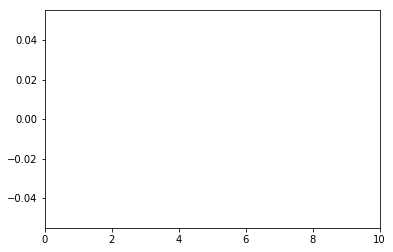

In [100]:
plt.hist(min_diam_sums, facecolor='k', alpha=0.4)
plt.hist(mid_diam_sums, facecolor='r', alpha=0.4)
plt.hist(avg_diam_sums, facecolor='b', alpha=0.4)
plt.xlim(0, 10)